# Tutorial / Proof of Concept for BDI+Kinetic Modeling

# Packages

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import pickle

from convenience import reformat_local_parameters
from kineticmodel_bdi import KineticModel
from kineticmodel_bdi.bayesian_framework import Likelihood, FixStandardDeviation

# Define model

## reactions

Every reaction is a list:

1. The first entry is a dictionary with all educts and their stoichiometry.
2. The second entry is a dictionary with all products and their stoichiometry.
3. The last entry is a string containing the name of the rate constant.

In [2]:
adsorption_equilibrium =  [[{'A': 1, 'S': 1}, {'AS': 1}, 'ka'],
                           [{'AS': 1}, {'A': 1, 'S': 1}, 'kd']]

In [3]:
ER_reactions = copy.deepcopy(adsorption_equilibrium)
ER_reactions.append([{'A': 1, 'AS': 1}, {'A': 1, 'S': 1, 'P': 1}, 'k_ER'])

In [4]:
LH_reactions = copy.deepcopy(adsorption_equilibrium)
LH_reactions.append([{'AS': 2}, {'AS': 1, 'P': 1, 'S': 1}, 'k_LH'])

## true parameters

We define the "true" parameters of the data at hand. Note that we always give parameters as log10.

In [5]:
true_parameters_reduced = pd.Series({'KA': 8., 
                                     'kd': -2.2, 
                                     'k': -2.2, 
                                     'S0': -8.,
                                     'sigma_kin': -7.,
                                     'sigma_ads': -9.})

true_parameters_reduced                        

KA           8.0
S0          -8.0
k           -2.2
kd          -2.2
sigma_ads   -9.0
sigma_kin   -7.0
dtype: float64

We'll store the true parameters in a csv file for future use (in other notebooks).

In [6]:
# true_parameters_reduced.to_csv('true_parameters_reduced.csv')

Some parameters need to be calculated from other ones before we get the full set of parameters.
If you're interested in how this is done, refer to convenience.py

In [7]:
true_parameters = reformat_local_parameters(true_parameters_reduced)
true_parameters

KA            8.0
S0           -8.0
k            -2.2
kd           -2.2
sigma_ads    -9.0
sigma_kin    -7.0
ka            5.8
k_LH         13.8
k_ER          5.8
dtype: float64

# Generate data

## Kinetic data

We start out with an empty dataframe

In [8]:
# time in seconds
timestep = 60
max_time = 450

times = np.arange(0, max_time + timestep, timestep)
T0 = [5e-7, 1e-6, 2e-6, 5e-6, 1e-5, 2e-5]
T0 = [1e-6, 2e-6, 5e-6]

empty_exp_data = pd.DataFrame(np.zeros((len(times), len(T0))), index=times, columns=T0)
empty_exp_data.columns.name = 'A'
empty_exp_data.index.name = 'time / s'

KineticModel requires experimental data as input, that's where the empty dataframe will go. Moreover, it requires a list of reactions and a pandas.Series of parameters.
Finally, we pass the list of educts.

In [9]:
true_kin_model = KineticModel(empty_exp_data, ER_reactions, true_parameters, educts=['A'])
true_kin_model.create_native_odesys()
true_kin_model.interactive_plot()

A Jupyter Widget

We can look at the reactions of the model and the corresponding rate constants

In [10]:
true_kin_model.model

Now we create an instance of `Likelihood` for the kinetics. This is useful to consistently calculate $p(D | \theta)$ and also to draw from the distribution

$[\mathrm{A}]^{\mathrm{observed}} \sim N([\mathrm{A}]^{\mathrm{model}}, \sigma)$

In [11]:
true_kin_likelihood = Likelihood(true_kin_model, FixStandardDeviation('sigma_kin'))

INFO:pyodesys.native._base:In "/tmp/tmpUxyPjG_pycodeexport_pyodesys_NativeCvodeCode", executing:
"/usr/bin/g++ -c -std=c++11 -Wall -Wextra -fPIC -O2 -ffast-math -funroll-loops -fopenmp -o ./odesys_anyode.o -I/home/niklas/anaconda2/lib/python2.7/site-packages/numpy/core/include -I/home/niklas/anaconda2/lib/python2.7/site-packages/pyodesys/native/sources -I/home/niklas/anaconda2/lib/python2.7/site-packages/pycvodes/include odesys_anyode.cpp"
INFO:pyodesys.native._base:In "/tmp/tmpUxyPjG_pycodeexport_pyodesys_NativeCvodeCode", executing:
"/usr/bin/g++ -pthread -shared -std=c++11 -Wall -Wextra -fPIC -O2 -ffast-math -funroll-loops -fopenmp -o /tmp/tmpUxyPjG_pycodeexport_pyodesys_NativeCvodeCode/_cvode_wrapper.so -I/home/niklas/anaconda2/lib/python2.7/site-packages/numpy/core/include -I/home/niklas/anaconda2/lib/python2.7/site-packages/pyodesys/native/sources -I/home/niklas/anaconda2/lib/python2.7/site-packages/pycvodes/include odesys_anyode.o _cvode_wrapper.o -lsundials_cvodes -lsundials_nv

We don't want any negative concentrations:

In [12]:
success = False
while not success:
    observed_kin_data = true_kin_likelihood.generate_D_from_theta(true_parameters)
    if (observed_kin_data < 0).sum().sum() == 0:
        success = True

We can store the kinetic data to a csv file now:

In [13]:
# observed_kin_data.to_csv('observed_kin_data.csv')

Plot the kinetic data:

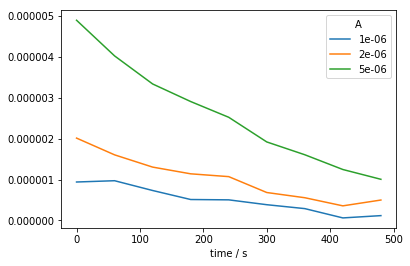

In [14]:
observed_kin_data.plot()

# Equilibrium adsorption

Kinetic models can be combined with anything that can be expressed as a function, e.g. the Langmuir isotherm

In [15]:
def langmuir_isotherm(A, KA, S0):
    KAA = A * KA
    return S0* KAA / (1 + KAA)

Generate an array of unbound [A]: this would be the x-Axis in the plot.

In [16]:
conc_A = np.power(10, np.arange(-8.5, -6.5, 1/5.))
conc_A

array([3.16227766e-09, 5.01187234e-09, 7.94328235e-09, 1.25892541e-08,
       1.99526231e-08, 3.16227766e-08, 5.01187234e-08, 7.94328235e-08,
       1.25892541e-07, 1.99526231e-07])

In [17]:
def calc_eq_adsorption(parameters):
    return langmuir_isotherm(conc_A, 10**parameters['KA'], 10**parameters['S0'])

In [18]:
true_eq_adsorption_data = pd.Series(calc_eq_adsorption(true_parameters), index=conc_A)

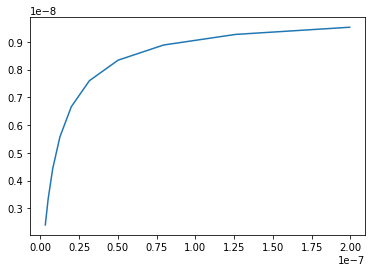

In [19]:
true_eq_adsorption_data.plot()

Again, we create a `Likelihood` instance, this time for the equilibrium adsorption.

In [20]:
true_eq_adsorption_likelihood = Likelihood(calc_eq_adsorption, FixStandardDeviation('sigma_ads'), exp_data_formatted=true_eq_adsorption_data)

In [21]:
success = False
while not success:
    observed_eq_adsorption_data = true_eq_adsorption_likelihood.generate_D_from_theta(true_parameters)
    if (observed_eq_adsorption_data < 0).sum().sum() == 0:
        success = True

Save the equilibrium adsorption data to a csv file and plot the stored data (including noise) to the noisefree data.

In [22]:
# observed_eq_adsorption_data.to_csv('observed_eq_adsorption_data.csv')

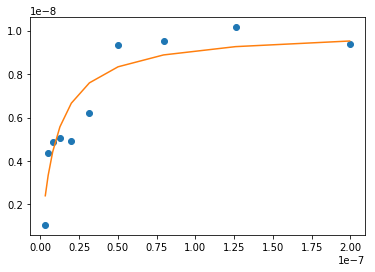

In [23]:
ax = observed_eq_adsorption_data.plot(style='o')
true_eq_adsorption_data.plot(ax=ax)

# Time-dependent (td) adsorption

Again, we need to create an empty dataframe to pass to KineticModel for the time-dependent adsorption.

In [24]:
td_adsorption_time = np.arange(0, 60, 5.)
empty_td_adsorption_data = pd.DataFrame({2.5e-8: [0]* len(td_adsorption_time), 
                                  5e-8: [0]* len(td_adsorption_time)}, index=td_adsorption_time)
empty_td_adsorption_data.columns.name = 'A'
empty_td_adsorption_data.index.name = 'time / s'

This time, we want to pass `observed_specis=[AS]` to monitor the concentration of the adsorbed protease.

In [25]:
true_td_adsorption = KineticModel(empty_td_adsorption_data, adsorption_equilibrium, true_parameters, educts='A', observed_species='AS')
true_td_adsorption.create_native_odesys()
true_td_adsorption.interactive_plot()

A Jupyter Widget

In [26]:
true_td_adsorption_likelihood = Likelihood(true_td_adsorption, FixStandardDeviation('sigma_ads'))

INFO:pyodesys.native._base:In "/tmp/tmpgPoNrt_pycodeexport_pyodesys_NativeCvodeCode", executing:
"/usr/bin/g++ -c -std=c++11 -Wall -Wextra -fPIC -O2 -ffast-math -funroll-loops -fopenmp -o ./odesys_anyode.o -I/home/niklas/anaconda2/lib/python2.7/site-packages/numpy/core/include -I/home/niklas/anaconda2/lib/python2.7/site-packages/pyodesys/native/sources -I/home/niklas/anaconda2/lib/python2.7/site-packages/pycvodes/include odesys_anyode.cpp"
INFO:pyodesys.native._base:In "/tmp/tmpgPoNrt_pycodeexport_pyodesys_NativeCvodeCode", executing:
"/usr/bin/g++ -pthread -shared -std=c++11 -Wall -Wextra -fPIC -O2 -ffast-math -funroll-loops -fopenmp -o /tmp/tmpgPoNrt_pycodeexport_pyodesys_NativeCvodeCode/_cvode_wrapper.so -I/home/niklas/anaconda2/lib/python2.7/site-packages/numpy/core/include -I/home/niklas/anaconda2/lib/python2.7/site-packages/pyodesys/native/sources -I/home/niklas/anaconda2/lib/python2.7/site-packages/pycvodes/include odesys_anyode.o _cvode_wrapper.o -lsundials_cvodes -lsundials_nv

In [27]:
success = False
while not success:
    observed_td_adsorption_data = true_td_adsorption_likelihood.generate_D_from_theta(true_parameters)
    if (observed_td_adsorption_data < 0).sum().sum() == 0:
        success = True

In [28]:
# observed_td_adsorption_data.index.name = 'time / s'
# observed_td_adsorption_data.columns.name = 'A'
# observed_td_adsorption_data.to_csv('observed_td_adsorption_data_complete.csv')

# # We should only model data points where assumption of normal distribution is acceptable
# observed_td_adsorption_data.loc[10:].to_csv('observed_td_adsorption_data.csv')

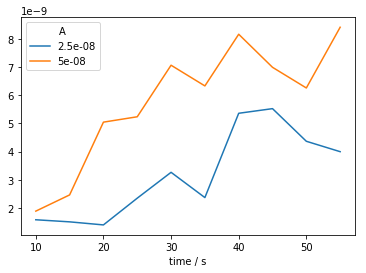

In [29]:
observed_td_adsorption_data.loc[10:].plot()